# Simple timeseries analysis

In this Notebook you will learn to perform different kinds of analysis on timeseries data

Seaborn is a powerful library to visualise informative statistical graphics (https://seaborn.pydata.org/index.html)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa import seasonal

from datascience.read import Era5, AscatDataH121, read_multiple_ds

%matplotlib widget

We will look at ERA5 and ASCAT data in this notebook. The reading and filtering of valid data is identical as in the previous notebooks.

In [2]:
era5 = Era5(read_bulk = False)
ascat = AscatDataH121(read_bulk = False)

In [3]:
lat = 48.198905
lon = 16.367182
gpi = era5.grid.find_nearest_gpi(lon, lat)[0]

In [4]:
ts = read_multiple_ds(loc=(lon, lat), ascat=ascat, era5=era5, ref_ds="ascat")

ASCAT GPI: 1227274 - distance: 5527.400 m
ERA5 GPI: 240545 - distance: 10396.479 m


In [5]:
not_valid = (ts["stl1_era5"] < 0) | (ts["sd"] > 0)
ts.loc[:,"sm_valid"] = ~not_valid
ts_valid = ts.loc[ts["sm_valid"]]
ts_valid = ts_valid.dropna()

## Linear regression

To find the correlation between two variables you can scatterplot them against eachother and use the linregress and pearsonr function to get numerical values. The resulting pearson statistic show the correlation between two variables, a small p-value(<0.05) show a statistical relevanve to this correlation. Note that the p-value is dependent on the size of the dataset, large datasets give small p-values independent on their statistical relevance.

In [6]:
linreg = stats.linregress(ts_valid["surface_soil_moisture"],  ts_valid["swvl1_era5"])
pearson = stats.pearsonr(ts_valid["surface_soil_moisture"],  ts_valid["swvl1_era5"])
pearson

PearsonRResult(statistic=0.5255224339927514, pvalue=0.0)

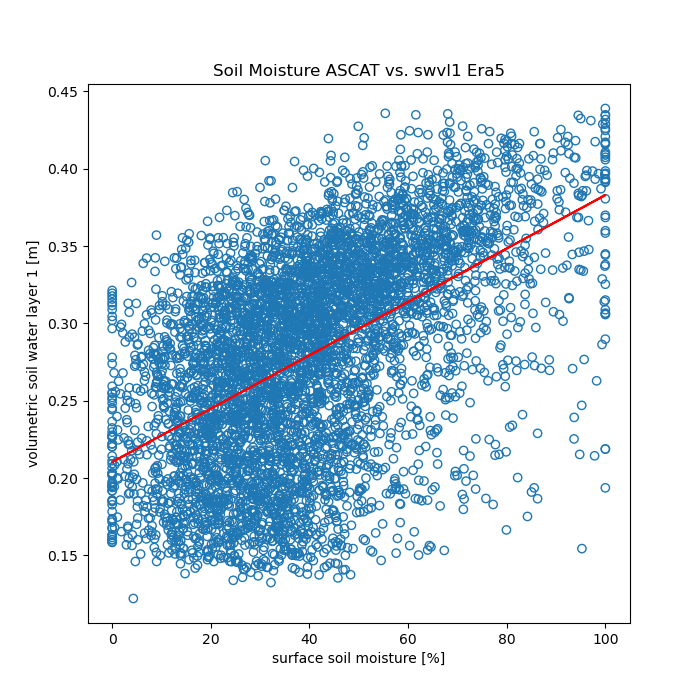

In [7]:
fig, ax = plt.subplots(figsize=(7,7))

kwargs = {"facecolors": "None", "edgecolor": "C0"}

ax.scatter(ts_valid["surface_soil_moisture"], ts_valid["swvl1_era5"], **kwargs)
ax.plot(ts_valid["surface_soil_moisture"], linreg.intercept+linreg.slope*ts_valid["surface_soil_moisture"], c="r")
ax.set_xlabel("surface soil moisture [%]")
ax.set_ylabel("volumetric soil water layer 1 [m]")
ax.set_title("Soil Moisture ASCAT vs. swvl1 Era5")

plt.show()

## Pairplot

You can also create a pairplot to see the visualise the correlation between more than two variables:

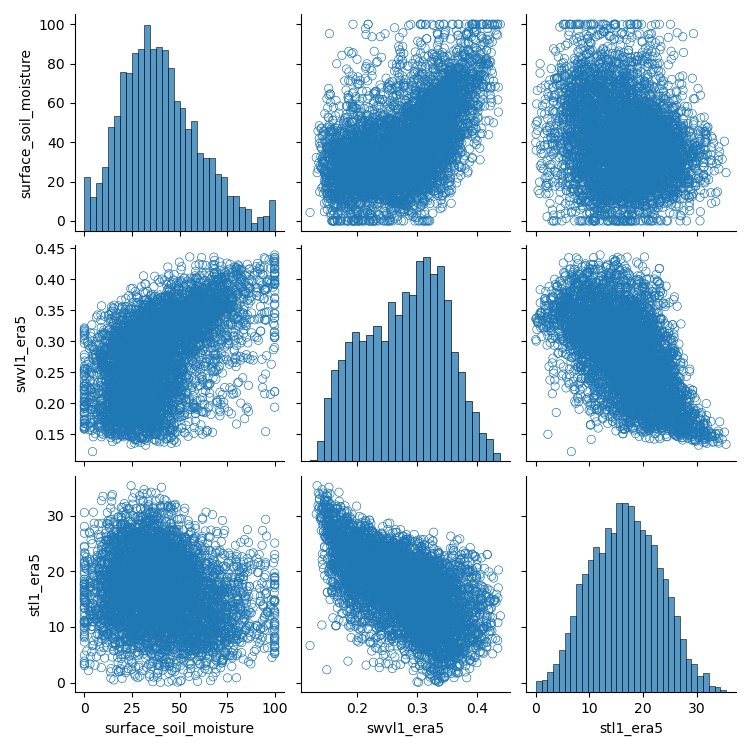

In [8]:
sns.pairplot(ts_valid, vars=["surface_soil_moisture", "swvl1_era5", "stl1_era5"], diag_kind="hist", plot_kws=kwargs)

## Boxplot

And create boxplots to see the distribution of values

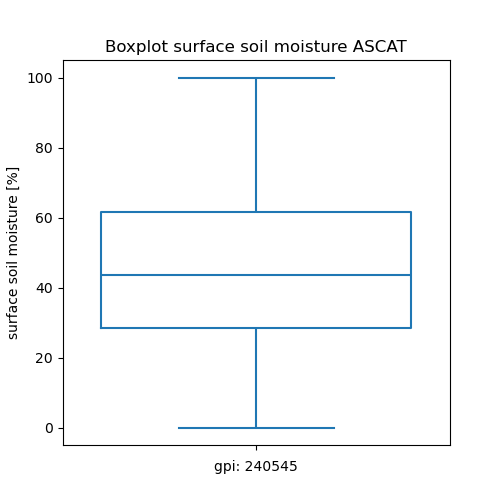

In [9]:
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(ts["surface_soil_moisture"], fill=False)
ax.set_title("Boxplot surface soil moisture ASCAT")
ax.set_ylabel("surface soil moisture [%]")
ax.set_xlabel(f"gpi: {gpi}")

plt.show()

## Seasonal Trend

Also, you can create seasonal trend analysis, beware that nan values might cause problems, as you need temporal consistent data. To do this you can also resample the data to a consistent time frame (beware that if you do this some variables are not meaningful anymore). The period should be chosen after how many entries the data repeats itself (e.g. if it repeats itself every year and you have data every 5 days the period is 365/5=73)

In [10]:
ts_resampled = ts.resample('5D').mean()
ts_resampled

,as_des_pass,swath_indicator,surface_soil_moisture,surface_soil_moisture_noise,backscatter40,slope40,curvature40,surface_soil_moisture_sensitivity,backscatter_flag,correction_flag,...,wetland_fraction,topographic_complexity,subsurface_scattering_probability,sat_id,sd,swvl1_era5,stl1_era5,t2m_era5,tp_era5,sm_valid
2007-01-01,0.500000,0.500000,57.178570,6.721428,-7.834577,-0.091697,0.000625,2.946471,6.375000,0.125000,...,0.0,5.0,NaN,3.000000,0.000019,0.304435,4.646645,6.492096,1.455587e-05,0.875000
2007-01-06,0.428571,0.428571,53.975002,6.628334,-7.970102,-0.092761,0.000685,2.988383,6.285714,0.142857,...,0.0,5.0,NaN,3.000000,0.000000,0.302399,7.158072,8.438646,4.841547e-05,1.000000
2007-01-11,0.500000,0.500000,45.881664,6.546667,-8.276898,-0.093967,0.000740,3.030756,5.750000,0.250000,...,0.0,5.0,NaN,3.000000,0.000000,0.294082,8.772675,9.845745,8.016359e-07,1.000000
2007-01-16,0.444444,0.444444,55.097500,6.516250,-7.992130,-0.095198,0.000764,3.062433,6.444444,0.111111,...,0.0,5.0,NaN,3.000000,0.000000,0.293578,4.792084,6.556830,5.309408e-05,0.888889
2007-01-21,0.500000,0.500000,64.865715,6.458571,-7.683101,-0.096589,0.000757,3.086193,6.375000,0.125000,...,0.0,5.0,NaN,3.000000,0.002861,0.325351,3.548679,1.811356,3.079979e-04,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-07,0.500000,0.437500,59.309998,7.390000,-7.745576,-0.093061,0.000700,2.715235,3.375000,0.250000,...,0.0,5.0,NaN,4.437500,NaN,NaN,NaN,NaN,NaN,1.000000
2024-01-12,0.466667,0.600000,37.356663,7.190000,-7.890452,-0.094304,0.000752,2.757598,3.666667,0.266667,...,0.0,5.0,NaN,4.466667,NaN,NaN,NaN,NaN,NaN,1.000000
2024-01-17,0.562500,0.437500,100.000000,7.410000,-7.620744,-0.095487,0.000762,2.783470,3.312500,0.875000,...,0.0,5.0,NaN,4.437500,NaN,NaN,NaN,NaN,NaN,1.000000
2024-01-22,0.533333,0.533333,92.644997,7.150000,-6.762565,-0.096808,0.000760,2.807610,3.400000,0.666667,...,0.0,5.0,NaN,4.533333,NaN,NaN,NaN,NaN,NaN,1.000000


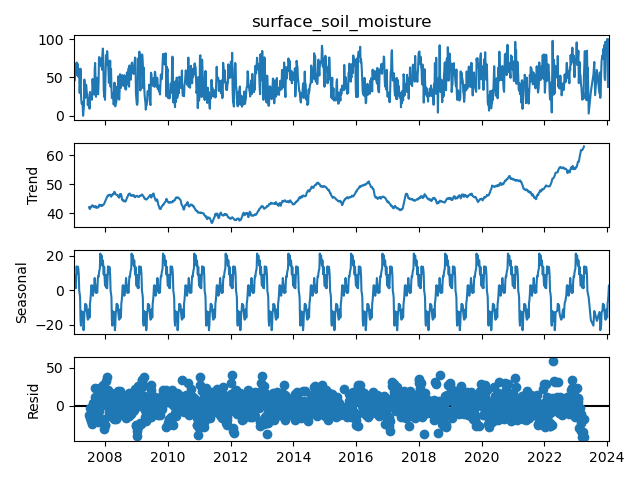

In [11]:
result = seasonal.seasonal_decompose(ts_resampled["surface_soil_moisture"].dropna(), model="additive", period=73)
result.plot()
plt.show()

You can also compare the trend of different variables:

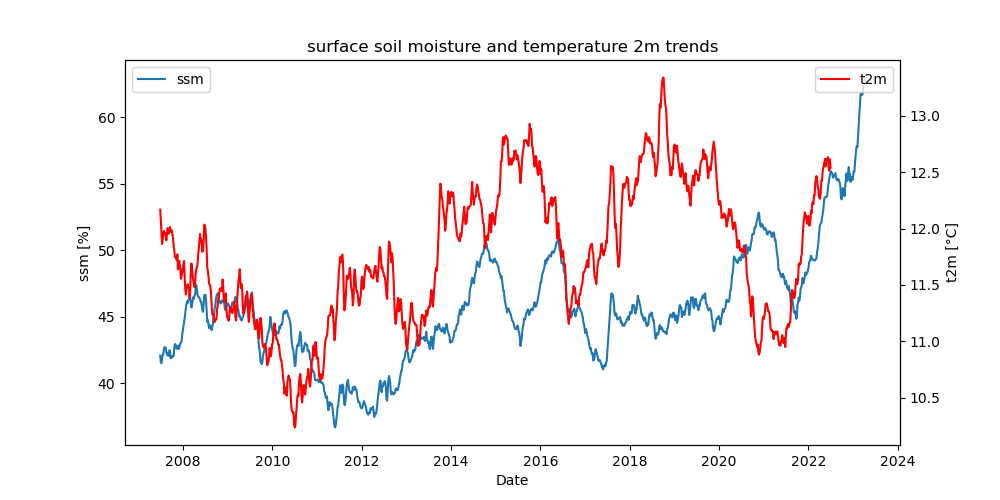

In [12]:
trend_ssm = seasonal.seasonal_decompose(ts_resampled["surface_soil_moisture"].dropna(), model="additive", period=73).trend
trend_t2m = seasonal.seasonal_decompose(ts_resampled["t2m_era5"].dropna(), model="additive", period=73).trend

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(trend_ssm, label="ssm")
ax1 = ax.twinx()
ax1.plot(trend_t2m, c="r", label="t2m")
ax.set_title("surface soil moisture and temperature 2m trends")
ax.set_ylabel("ssm [%]")
ax1.set_ylabel("t2m [°C]")
ax.set_xlabel("Date")
ax.legend()
ax1.legend()

plt.show()